In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime

In [8]:
start = datetime.datetime(1967, 1, 7)
end = datetime.datetime(2024, 2, 24)
icnsa_df = web.DataReader('ICNSA', 'fred', start, end)

<Axes: xlabel='DATE'>

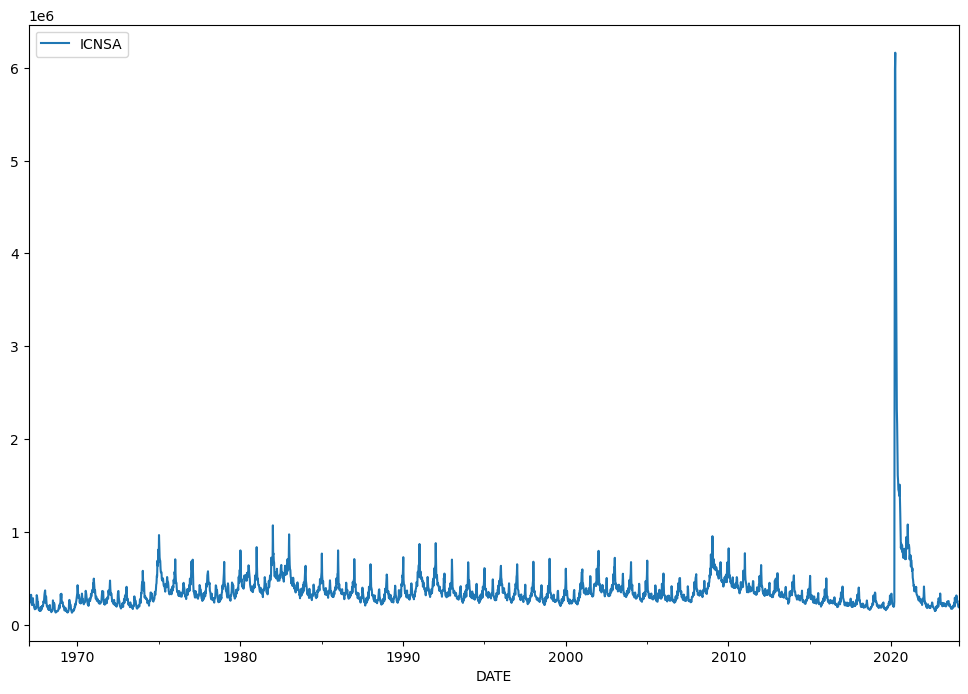

In [9]:
icnsa_df.plot(figsize=(12,8))

In [14]:
icnsa_df.index

DatetimeIndex(['1967-01-07', '1967-01-14', '1967-01-21', '1967-01-28',
               '1967-02-04', '1967-02-11', '1967-02-18', '1967-02-25',
               '1967-03-04', '1967-03-11',
               ...
               '2023-12-23', '2023-12-30', '2024-01-06', '2024-01-13',
               '2024-01-20', '2024-01-27', '2024-02-03', '2024-02-10',
               '2024-02-17', '2024-02-24'],
              dtype='datetime64[ns]', name='DATE', length=2982, freq=None)

In [10]:
unemprate_df = web.DataReader('UNRATE', 'fred', start, end)

<Axes: xlabel='DATE'>

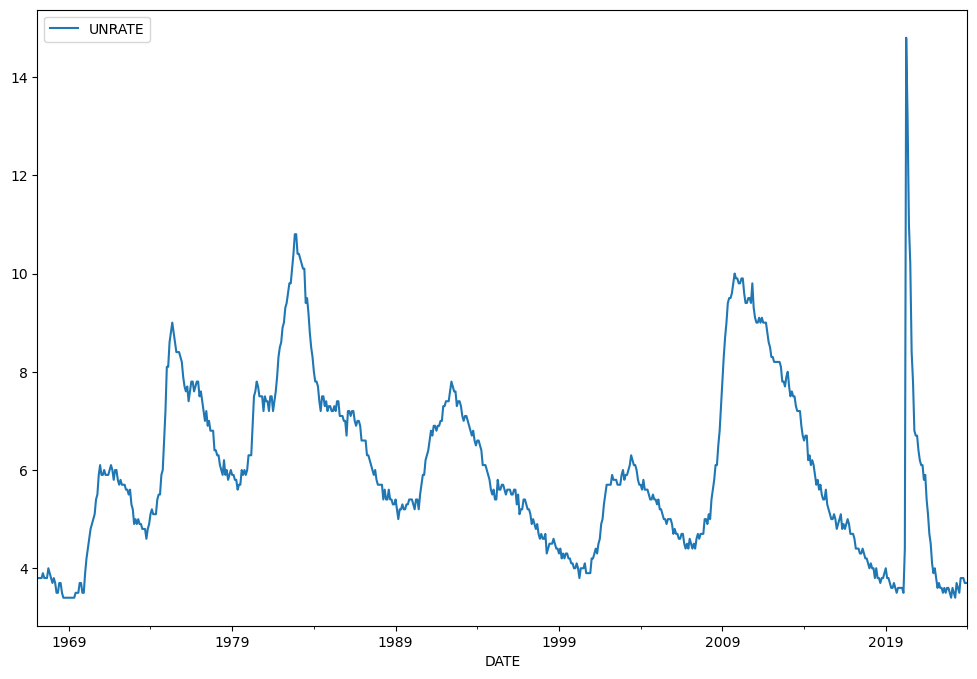

In [11]:
unemprate_df.plot(figsize=(12,8))

In [12]:
unemprate_df.index

DatetimeIndex(['1967-02-01', '1967-03-01', '1967-04-01', '1967-05-01',
               '1967-06-01', '1967-07-01', '1967-08-01', '1967-09-01',
               '1967-10-01', '1967-11-01',
               ...
               '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01',
               '2023-12-01', '2024-01-01'],
              dtype='datetime64[ns]', name='DATE', length=684, freq=None)

Checking for covid start and end dates

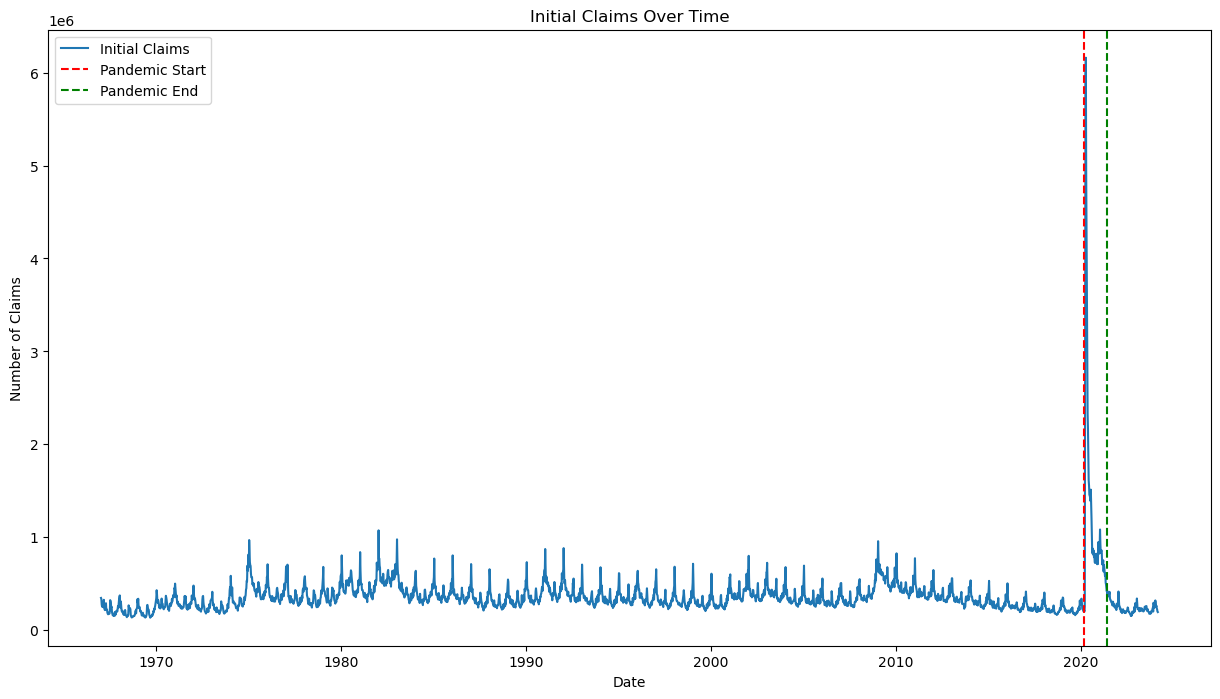

In [16]:
plt.figure(figsize=(15, 8))
plt.plot(icnsa_df.index, icnsa_df['ICNSA'], label='Initial Claims')

plt.axvline(x=pd.Timestamp('2020-03-01'), color='r', linestyle='--', label='Pandemic Start')
plt.axvline(x=pd.Timestamp('2021-06-01'), color='g', linestyle='--', label='Pandemic End')

plt.title('Initial Claims Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Claims')
plt.legend()
plt.show()

In [17]:
print(start)

1967-01-07 00:00:00


C:\Users\princ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\princ\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['robust']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


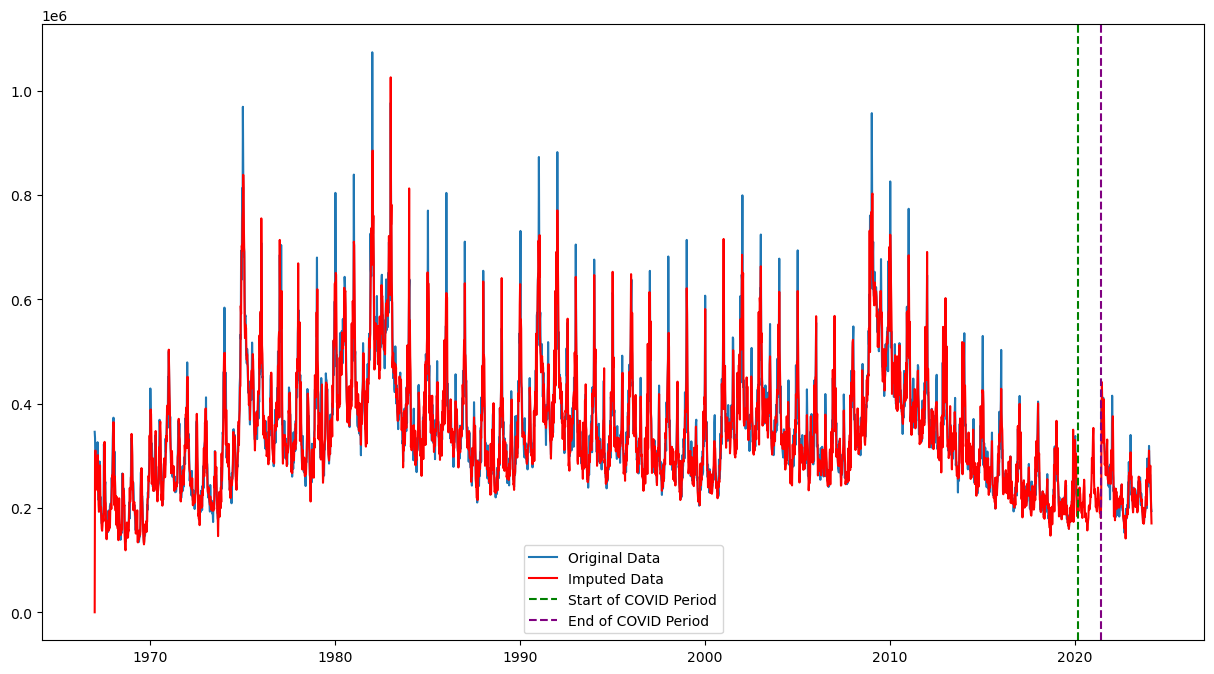

In [18]:
from statsmodels.tsa.statespace.structural import UnobservedComponents


start_index = datetime.datetime(2020, 3, 1)
end_index = datetime.datetime(2021, 6, 1)

icnsa_df.loc[start_index:end_index, 'ICNSA'] = np.nan

model = UnobservedComponents(icnsa_df['ICNSA'], 
                             level='llevel',  
                             seasonal=52,     
                             freq_seasonal=[{'period': 52, 'harmonics': 4}], 
                             autoregressive=1,
                             robust=True)  

results = model.fit()

# Impute the missing values using the predict method , it uses the Kalman Smoother internally for the imputation
icnsa_df['Imputed_ICNSA'] = results.predict()

# Plot the series with imputed values
plt.figure(figsize=(15, 8))
plt.plot(icnsa_df.index, icnsa_df['ICNSA'], label='Original Data')
plt.plot(icnsa_df.index, icnsa_df['Imputed_ICNSA'], label='Imputed Data', color='red')
plt.axvline(x=pd.Timestamp('2020-03-01'), color='green', linestyle='--', label='Start of COVID Period')
plt.axvline(x=pd.Timestamp('2021-06-01'), color='purple', linestyle='--', label='End of COVID Period')
plt.legend()
plt.show()

In [28]:
df = icnsa_df.resample('M').mean()
df=df.iloc[1:len(df)-1]
df.head()

,ICNSA,Imputed_ICNSA
DATE,,
1967-02-28,261250.0,248886.071989
1967-03-31,251500.0,246429.569837
1967-04-30,239400.0,227111.922747
1967-05-31,189000.0,183164.807883
1967-06-30,179250.0,171224.576739


In [29]:
unemprate_df.index = unemprate_df.index + pd.offsets.MonthEnd(0) 

In [30]:
unemprate_df.head()

,UNRATE
DATE,
1967-02-28,3.8
1967-03-31,3.8
1967-04-30,3.8
1967-05-31,3.8
1967-06-30,3.9


In [32]:
df['Unemployment_Rate'] = unemprate_df['UNRATE']
df.head()

,ICNSA,Imputed_ICNSA,Unemployment_Rate
DATE,,,
1967-02-28,261250.0,248886.071989,3.8
1967-03-31,251500.0,246429.569837,3.8
1967-04-30,239400.0,227111.922747,3.8
1967-05-31,189000.0,183164.807883,3.8
1967-06-30,179250.0,171224.576739,3.9


In [33]:
from pmdarima import auto_arima

# Assuming 'values' is the column you want to use for time series forecasting
values = df['Imputed_ICNSA']

# Perform auto_arima on the numerical values
auto_arima(values,suppress_warnings=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  684
Model:               SARIMAX(5, 1, 4)   Log Likelihood               -8281.046
Date:                Thu, 07 Mar 2024   AIC                          16582.092
Time:                        14:56:41   BIC                          16627.357
Sample:                    02-28-1967   HQIC                         16599.609
                         - 01-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0137      0.066     -0.208      0.835      -0.143       0.115
ar.L2         -0.9973      0.007   -151.378      0.000      -1.010      -0.984
ar.L3         -0.0162      0.065     -0.248      0.804      -0.144       0.112
ar.L4         -0.9919      0.006   -171.800      0.000      -1.003      -0.981
ar.L5         -0.0092      0.065     -0.142      0.887      -0.136       0.118
ma.L1         -0.0053      0.037     -0.145      0.885      -0.077       0.066
ma.L2          1.0095      0.034     29.706      0.000       0.943       1.076
ma.L3          0.0269      0.038      0.711      0.477      -0.047       0.101
ma.L4          0.9229      0.034     27.057      0.000       0.856       0.990
sigma2      2.974e+09   7.56e-12   3.93e+20      0.000    2.97e+09    2.97e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                48.17
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.98e+36. Standard errors may be unstable.
"""

In [40]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df['Imputed_ICNSA'], 
                        exog=df['Unemployment_Rate'], 
                        order=(5, 1, 4)
                     )

arima_results = arima_model.fit()

C:\Users\princ\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
# Assuming 'values' is the column you want to use for time series forecasting
values = df['Unemployment_Rate']

# Perform auto_arima on the numerical values
auto_arima(values,suppress_warnings=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  684
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -429.382
Date:                Thu, 07 Mar 2024   AIC                            864.764
Time:                        15:06:46   BIC                            878.343
Sample:                    02-28-1967   HQIC                           870.019
                         - 01-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7328      0.081     -9.084      0.000      -0.891      -0.575
ma.L1          0.8026      0.077     10.448      0.000       0.652       0.953
sigma2         0.2059      0.001    244.154      0.000       0.204       0.208
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):           4414989.97
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):              12.82   Skew:                            17.00
Prob(H) (two-sided):                  0.00   Kurtosis:                       395.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
from statsmodels.tsa.arima.model import ARIMA

# Forecast the next period's UNEMPRATE value
unemprate_model = ARIMA(df['Unemployment_Rate'], order=(1, 1, 1))
unemprate_results = unemprate_model.fit()
next_exog_rate = unemprate_results.forecast(steps=1)

In [43]:
forecast = arima_results.get_forecast(steps=1, exog=next_exog_rate)
forecast_value = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
print(forecast_value)

2024-02-29    221637.380573
Freq: M, dtype: float64
